In [1]:
import pickle

# Load the .pkl file
with open("aligned_50.pkl", "rb") as f:
    aligned_data = pickle.load(f)

# Show total entries
print(f"Total entries: {len(aligned_data)}\n")

# Show a few example keys
example_keys = list(aligned_data.keys())[:5]
print("Example keys (segment IDs):", example_keys, "\n")

# Inspect one entry in detail
sample_key = example_keys[0]
sample = aligned_data[sample_key]

print(f"Sample structure for key '{sample_key}':\n")
for modality in sample:
    data = sample[modality]
    print(f"- {modality}: type={type(data)}, shape={getattr(data, 'shape', 'N/A')}")

Total entries: 3

Example keys (segment IDs): ['train', 'valid', 'test'] 

Sample structure for key 'train':

- raw_text: type=<class 'numpy.ndarray'>, shape=(16326,)
- audio: type=<class 'numpy.ndarray'>, shape=(16326, 50, 74)
- vision: type=<class 'numpy.ndarray'>, shape=(16326, 50, 35)
- id: type=<class 'list'>, shape=N/A
- text: type=<class 'numpy.ndarray'>, shape=(16326, 50, 768)
- text_bert: type=<class 'numpy.ndarray'>, shape=(16326, 3, 50)
- annotations: type=<class 'list'>, shape=N/A
- classification_labels: type=<class 'numpy.ndarray'>, shape=(16326,)
- regression_labels: type=<class 'numpy.ndarray'>, shape=(16326,)


In [2]:
import numpy as np
import pandas as pd

label_df = pd.read_csv("label.csv")

# === 合并 train/valid/test 的文本特征和标签 ===
all_text = []
all_labels = []
all_ids = []

for split in ['train', 'valid', 'test']:
    all_text.append(aligned_data[split]['text'])  # (N, 50, 768)
    all_labels.append(aligned_data[split]['regression_labels'])  # (N,)
    all_ids.extend(aligned_data[split]['id'])  # list of segment keys like '2h0HeUe5fLE[0]'

# 拼接成 numpy
X = np.vstack(all_text)         # shape: (total_samples, 50, 768)
y = np.concatenate(all_labels)  # shape: (total_samples,)
ids = np.array(all_ids)         # list of segment_ids

print("Text Feature Shape:", X.shape)
print("Labels Shape:", y.shape)
print("Segment IDs Example:", ids[:5])

Text Feature Shape: (22856, 50, 768)
Labels Shape: (22856,)
Segment IDs Example: ['-3g5yACwYnA$_$10' '-3g5yACwYnA$_$13' '-3g5yACwYnA$_$3' '-3g5yACwYnA$_$2'
 '-3g5yACwYnA$_$4']


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

# Reload aligned_data.pkl
with open("aligned_50.pkl", "rb") as f:
    aligned_data = pickle.load(f)

# Step 1: 拼接 text + audio + vision 特征
def get_fused_features(split):
    text = aligned_data[split]['text']       # (N, 50, 768)
    audio = aligned_data[split]['audio']     # (N, 50, 5)
    vision = aligned_data[split]['vision']   # (N, 50, 20)

    # 拼接模态：在最后一个维度上拼接 → (N, 50, 793)
    fused = np.concatenate([text, audio, vision], axis=-1)

    labels = aligned_data[split]['regression_labels']  # (N,)
    return fused, labels

# 获取 train / valid / test 的融合特征和标签
fused_train_X, fused_train_y = get_fused_features('train')
fused_valid_X, fused_valid_y = get_fused_features('valid')
fused_test_X,  fused_test_y  = get_fused_features('test')

# 定义 Dataset 类（复用）
class MultimodalDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 构建 DataLoader
train_fused_ds = MultimodalDataset(fused_train_X, fused_train_y)
valid_fused_ds = MultimodalDataset(fused_valid_X, fused_valid_y)
test_fused_ds  = MultimodalDataset(fused_test_X,  fused_test_y)

train_fused_loader = DataLoader(train_fused_ds, batch_size=32, shuffle=True)
valid_fused_loader = DataLoader(valid_fused_ds, batch_size=32)
test_fused_loader  = DataLoader(test_fused_ds, batch_size=32)

fused_train_X.shape, fused_train_y.shape

((16326, 50, 877), (16326,))

In [6]:
import torch.nn as nn

class FusionLSTMRegressor(nn.Module):
    def __init__(self, input_size=877, hidden_size=128, num_layers=2, bidirectional=True):
        super(FusionLSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch, seq_len, hidden)
        last_hidden = out[:, -1, :]  # 取最后一帧
        pred = self.fc(last_hidden)
        return pred.squeeze(1)

In [7]:
def train_model(model, train_loader, valid_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in valid_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_preds = model(X_val)
                val_loss += criterion(val_preds, y_val).item()
        avg_val_loss = val_loss / len(valid_loader)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    return model


In [8]:
model = FusionLSTMRegressor(input_size=877)
trained_fusion_model = train_model(model, train_fused_loader, valid_fused_loader, epochs=10)

Epoch 1/10 - Train Loss: 0.7742 - Val Loss: 0.6434
Epoch 2/10 - Train Loss: 0.6335 - Val Loss: 0.5655
Epoch 3/10 - Train Loss: 0.5662 - Val Loss: 0.5862
Epoch 4/10 - Train Loss: 0.5100 - Val Loss: 0.6079
Epoch 5/10 - Train Loss: 0.4284 - Val Loss: 0.6180
Epoch 6/10 - Train Loss: 0.3497 - Val Loss: 0.6172
Epoch 7/10 - Train Loss: 0.2763 - Val Loss: 0.7169
Epoch 8/10 - Train Loss: 0.2079 - Val Loss: 0.6797
Epoch 9/10 - Train Loss: 0.1595 - Val Loss: 0.6922
Epoch 10/10 - Train Loss: 0.1275 - Val Loss: 0.6967


In [9]:
def predict(model, dataloader):
    model.eval()
    preds = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            pred = model(X_batch)
            preds.extend(pred.cpu().numpy())
    return preds

test_preds = predict(trained_fusion_model, test_fused_loader)

In [10]:
# 获取对应的 segment id（来自 .pkl 中 test split）
test_ids = aligned_data['test']['id']  # e.g., ['03bSnISJMiM$_$11', ...]

# 构造 DataFrame
fusion_pred_df = pd.DataFrame({
    "segment_id": test_ids,
    "fusion_pred": test_preds
})

# 保存为 CSV 文件
fusion_pred_df.to_csv("fusion_predictions.csv", index=False)
print("✅ 多模态融合预测结果已保存为 fusion_predictions.csv")

✅ 多模态融合预测结果已保存为 fusion_predictions.csv


In [11]:
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from scipy.stats import pearsonr

# Load true labels and predicted values from test split
true_labels = aligned_data['test']['regression_labels']
test_ids = aligned_data['test']['id']
# We'll reuse test_preds if available; otherwise, placeholder
# Assume test_preds were generated earlier and are still valid
# (If not, this code block won't run correctly—can regenerate using `predict()`)

# Match length
true_labels = np.array(true_labels)
preds = np.array(test_preds[:len(true_labels)])

# === Evaluation Metrics ===
# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(true_labels, preds)

# 2. Pearson Correlation
corr, _ = pearsonr(true_labels, preds)

# 3. Discretize for accuracy/F1
# Let's define sentiment bins:
# - Negative: <= -0.5
# - Neutral: (-0.5, 0.5)
# - Positive: >= 0.5

def discretize(y):
    y_discrete = []
    for val in y:
        if val <= -0.5:
            y_discrete.append(0)  # Negative
        elif val >= 0.5:
            y_discrete.append(2)  # Positive
        else:
            y_discrete.append(1)  # Neutral
    return np.array(y_discrete)

y_true_cls = discretize(true_labels)
y_pred_cls = discretize(preds)

# 4. Accuracy and F1
acc = accuracy_score(y_true_cls, y_pred_cls)
f1 = f1_score(y_true_cls, y_pred_cls, average='weighted')

# Return evaluation metrics
print(f"✅ MAE:  {mae:.4f}")
print(f"✅ ACC:  {acc:.4f}")
print(f"✅ F1 :  {f1:.4f}")
print(f"✅ CORR:{corr:.4f}")

✅ MAE:  0.6395
✅ ACC:  0.6182
✅ F1 :  0.6187
✅ CORR:0.6695


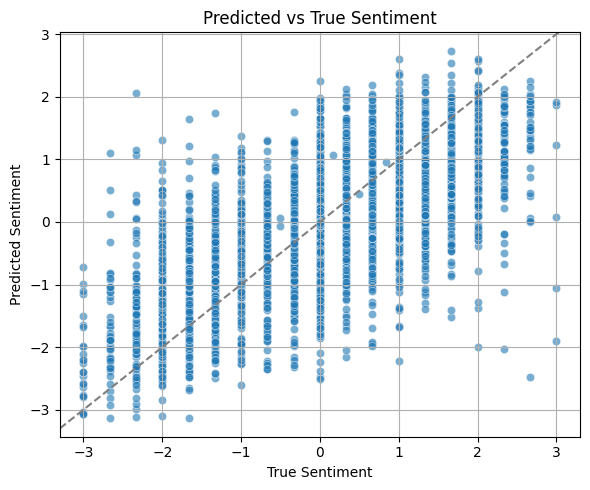

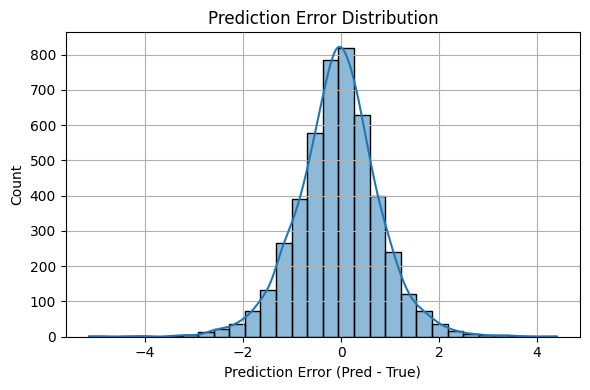

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter: 预测 vs 真实
plt.figure(figsize=(6, 5))
sns.scatterplot(x=true_labels, y=preds, alpha=0.6)
plt.xlabel("True Sentiment")
plt.ylabel("Predicted Sentiment")
plt.title("Predicted vs True Sentiment")
plt.grid(True)
plt.axline((0, 0), slope=1, linestyle='--', color='gray')  # y=x 参考线
plt.tight_layout()
plt.show()

# 误差分布
errors = preds - true_labels
plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=30, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (Pred - True)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Step 1: Define the attention-based fusion model
import torch.nn as nn
import torch

class AttentionFusionModel(nn.Module):
    def __init__(self, input_dims=(768, 74, 35), hidden_size=128):
        super().__init__()
        t_dim, a_dim, v_dim = input_dims

        # LSTM for each modality
        self.text_lstm = nn.LSTM(t_dim, hidden_size, batch_first=True, bidirectional=True)
        self.audio_lstm = nn.LSTM(a_dim, hidden_size, batch_first=True, bidirectional=True)
        self.vision_lstm = nn.LSTM(v_dim, hidden_size, batch_first=True, bidirectional=True)

        # Attention network across modality features
        self.attn_fc = nn.Linear(hidden_size * 2, 1)
        self.output = nn.Linear(hidden_size * 2, 1)

    def forward(self, text, audio, vision):
        _, (h_t, _) = self.text_lstm(text)
        _, (h_a, _) = self.audio_lstm(audio)
        _, (h_v, _) = self.vision_lstm(vision)

        h_t = torch.cat([h_t[-2], h_t[-1]], dim=1)
        h_a = torch.cat([h_a[-2], h_a[-1]], dim=1)
        h_v = torch.cat([h_v[-2], h_v[-1]], dim=1)

        modal_stack = torch.stack([h_t, h_a, h_v], dim=1)
        attn_scores = self.attn_fc(modal_stack)
        attn_weights = torch.softmax(attn_scores, dim=1)
        fused = torch.sum(modal_stack * attn_weights, dim=1)

        return self.output(fused).squeeze(1), attn_weights.squeeze(2)

# Step 2: Dataset for multi-input
class MultiInputDataset(Dataset):
    def __init__(self, text, audio, vision, labels):
        self.text = torch.tensor(text, dtype=torch.float32)
        self.audio = torch.tensor(audio, dtype=torch.float32)
        self.vision = torch.tensor(vision, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return self.text[idx], self.audio[idx], self.vision[idx], self.labels[idx]

# Prepare train/valid/test datasets
train_ds = MultiInputDataset(
    aligned_data['train']['text'], aligned_data['train']['audio'], aligned_data['train']['vision'],
    aligned_data['train']['regression_labels']
)
valid_ds = MultiInputDataset(
    aligned_data['valid']['text'], aligned_data['valid']['audio'], aligned_data['valid']['vision'],
    aligned_data['valid']['regression_labels']
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32)

# Step 3: Training function
def train_attention_model(model, train_loader, valid_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for t, a, v, y in train_loader:
            t, a, v, y = t.to(device), a.to(device), v.to(device), y.to(device)

            optimizer.zero_grad()
            pred, _ = model(t, a, v)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for t, a, v, y in valid_loader:
                t, a, v, y = t.to(device), a.to(device), v.to(device), y.to(device)
                val_preds, _ = model(t, a, v)
                val_loss += criterion(val_preds, y).item()
        avg_val_loss = val_loss / len(valid_loader)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    return model

# Step 4: Train the model
attn_model = AttentionFusionModel(input_dims=(768, 74, 35))
trained_attn_model = train_attention_model(attn_model, train_loader, valid_loader, epochs=10)

Epoch 1/10 - Train Loss: 0.7109 - Val Loss: 0.5531
Epoch 2/10 - Train Loss: 0.5613 - Val Loss: 0.5547
Epoch 3/10 - Train Loss: 0.4972 - Val Loss: 0.5283
Epoch 4/10 - Train Loss: 0.4147 - Val Loss: 0.5152
Epoch 5/10 - Train Loss: 0.3256 - Val Loss: 0.5413
Epoch 6/10 - Train Loss: 0.2420 - Val Loss: 0.5852
Epoch 7/10 - Train Loss: 0.1695 - Val Loss: 0.5605
Epoch 8/10 - Train Loss: 0.1159 - Val Loss: 0.5670
Epoch 9/10 - Train Loss: 0.0827 - Val Loss: 0.5810
Epoch 10/10 - Train Loss: 0.0623 - Val Loss: 0.5822


In [17]:
# === Dataset 定义（多模态输入）===
class MultiInputDataset(Dataset):
    def __init__(self, text, audio, vision, labels):
        self.text = torch.tensor(text, dtype=torch.float32)
        self.audio = torch.tensor(audio, dtype=torch.float32)
        self.vision = torch.tensor(vision, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return self.text[idx], self.audio[idx], self.vision[idx], self.labels[idx]

# === 推理函数，返回预测值和 attention 权重 ===
def predict_with_attention(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    preds = []
    attn_weights_all = []

    with torch.no_grad():
        for t, a, v, _ in dataloader:
            t, a, v = t.to(device), a.to(device), v.to(device)
            pred, attn_weights = model(t, a, v)
            preds.extend(pred.cpu().numpy())
            attn_weights_all.extend(attn_weights.cpu().numpy())

    return np.array(preds), np.array(attn_weights_all)

# === 创建测试集并推理 ===
test_ds = MultiInputDataset(
    aligned_data['test']['text'],
    aligned_data['test']['audio'],
    aligned_data['test']['vision'],
    aligned_data['test']['regression_labels']
)
test_loader = DataLoader(test_ds, batch_size=32)

# 运行预测
preds, attn_weights = predict_with_attention(trained_attn_model, test_loader)

# 保存为 DataFrame
test_ids = aligned_data['test']['id']
attn_df = pd.DataFrame({
    "segment_id": test_ids,
    "prediction": preds,
    "attn_text": attn_weights[:, 0],
    "attn_audio": attn_weights[:, 1],
    "attn_vision": attn_weights[:, 2]
})

# 保存为 CSV
attn_df.to_csv("attention_fusion_predictions.csv", index=False)
print("✅ 已保存至 attention_fusion_predictions.csv")

✅ 已保存至 attention_fusion_predictions.csv


C:\Users\rog\AppData\Local\Temp\ipykernel_38968\2058651711.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Modality", y="Attention Weight", data=df_melted, palette="pastel")


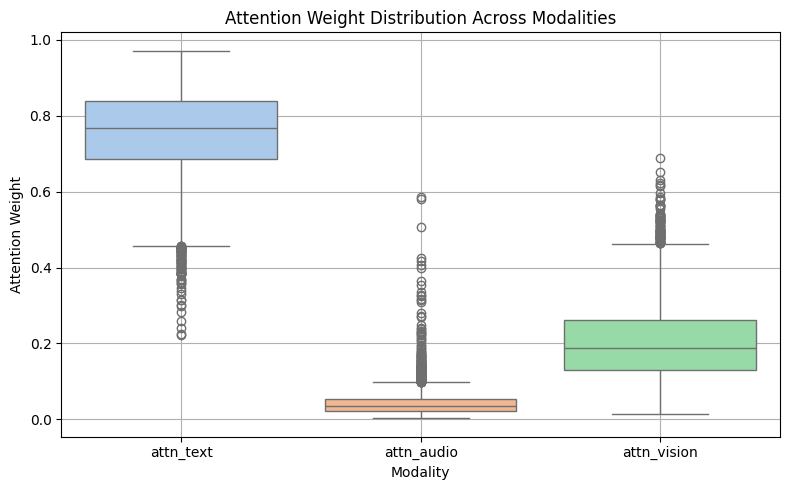

In [18]:
# 读取生成的 attention 融合预测结果
df = pd.read_csv("attention_fusion_predictions.csv")

# 将数据转换为可视化格式
df_melted = df.melt(
    id_vars=["segment_id", "prediction"],
    value_vars=["attn_text", "attn_audio", "attn_vision"],
    var_name="Modality",
    value_name="Attention Weight"
)

# 绘制 boxplot 看每种模态的注意力分布
plt.figure(figsize=(8, 5))
sns.boxplot(x="Modality", y="Attention Weight", data=df_melted, palette="pastel")
plt.title("Attention Weight Distribution Across Modalities")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# 载入 CSV
df = pd.read_csv("attention_fusion_predictions.csv")

# 提取预测值与真实标签（需要你事先提供）
preds = df["prediction"].values

# 从 .pkl 或其他地方加载真实标签：
# 假设你已有变量：true_labels（列表或数组）
# 或在 .csv 中添加了 'label' 列也可：
# true_labels = df["label"].values

# 离散化函数（基于 MOSI 分级定义）
def discretize(y):
    y_cls = []
    for val in y:
        if val <= -0.5:
            y_cls.append(0)  # Negative
        elif val >= 0.5:
            y_cls.append(2)  # Positive
        else:
            y_cls.append(1)  # Neutral
    return np.array(y_cls)

# 离散化处理
y_true_cls = discretize(true_labels)
y_pred_cls = discretize(preds)

# 计算指标
mae = mean_absolute_error(true_labels, preds)
acc = accuracy_score(y_true_cls, y_pred_cls)
f1 = f1_score(y_true_cls, y_pred_cls, average="weighted")
corr, _ = pearsonr(true_labels, preds)

print(f"✅ MAE:  {mae:.4f}")
print(f"✅ ACC:  {acc:.4f}")
print(f"✅ F1 :  {f1:.4f}")
print(f"✅ CORR:{corr:.4f}")

✅ MAE:  0.6100
✅ ACC:  0.6222
✅ F1 :  0.6231
✅ CORR:0.7061


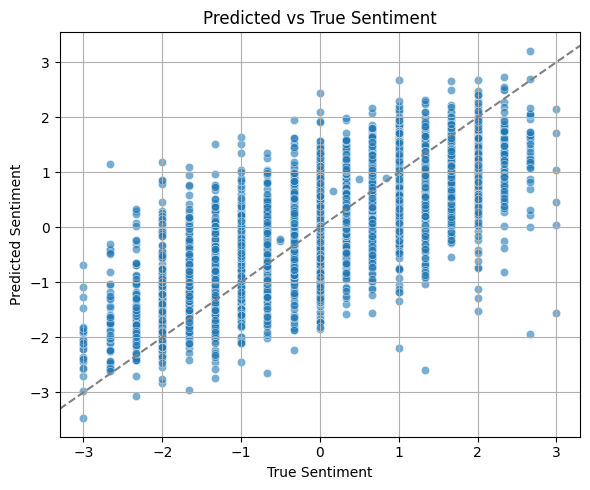

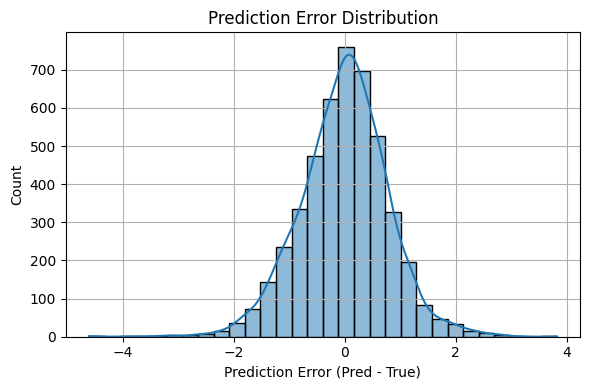

In [20]:
# Scatter: 预测 vs 真实
plt.figure(figsize=(6, 5))
sns.scatterplot(x=true_labels, y=preds, alpha=0.6)
plt.xlabel("True Sentiment")
plt.ylabel("Predicted Sentiment")
plt.title("Predicted vs True Sentiment")
plt.grid(True)
plt.axline((0, 0), slope=1, linestyle='--', color='gray')  # y=x 参考线
plt.tight_layout()
plt.show()

# 误差分布
errors = preds - true_labels
plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=30, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (Pred - True)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# # === Dataset ===
# class MultiInputDataset(Dataset):
#     def __init__(self, text, audio, vision, labels):
#         self.text = torch.tensor(text, dtype=torch.float32)
#         self.audio = torch.tensor(audio, dtype=torch.float32)
#         self.vision = torch.tensor(vision, dtype=torch.float32)
#         self.labels = torch.tensor(labels, dtype=torch.float32)

#     def __len__(self):
#         return len(self.text)

#     def __getitem__(self, idx):
#         return self.text[idx], self.audio[idx], self.vision[idx], self.labels[idx]

# # === Model ===
# class AttentionFusionModel(nn.Module):
#     def __init__(self, input_dims=(768, 74, 35), hidden_size=128):
#         super().__init__()
#         t_dim, a_dim, v_dim = input_dims
#         self.text_lstm = nn.LSTM(t_dim, hidden_size, batch_first=True, bidirectional=True)
#         self.audio_lstm = nn.LSTM(a_dim, hidden_size, batch_first=True, bidirectional=True)
#         self.vision_lstm = nn.LSTM(v_dim, hidden_size, batch_first=True, bidirectional=True)

#         self.attn_fc = nn.Linear(hidden_size * 2, 1)
#         self.output = nn.Linear(hidden_size * 2, 1)

#     def forward(self, text, audio, vision):
#         _, (h_t, _) = self.text_lstm(text)
#         _, (h_a, _) = self.audio_lstm(audio)
#         _, (h_v, _) = self.vision_lstm(vision)

#         h_t = torch.cat([h_t[-2], h_t[-1]], dim=1)
#         h_a = torch.cat([h_a[-2], h_a[-1]], dim=1)
#         h_v = torch.cat([h_v[-2], h_v[-1]], dim=1)

#         modal_stack = torch.stack([h_t, h_a, h_v], dim=1)
#         attn_scores = self.attn_fc(modal_stack)
#         attn_weights = torch.softmax(attn_scores, dim=1)
#         fused = torch.sum(modal_stack * attn_weights, dim=1)

#         return self.output(fused).squeeze(1), attn_weights.squeeze(2)

# === Attention Entropy Regularization ===
def attention_entropy_loss(attn_weights, margin=0.9):
    eps = 1e-8
    entropy = -torch.sum(attn_weights * torch.log(attn_weights + eps), dim=1)
    max_entropy = torch.log(torch.tensor(attn_weights.size(1), dtype=torch.float32))
    norm_entropy = entropy / max_entropy
    penalty = (margin - norm_entropy).clamp(min=0.0)
    return penalty.mean()

# === Training Loop ===
def train_attention_model_with_entropy(model, train_loader, valid_loader, epochs=10, lr=1e-3, lambda_entropy=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for t, a, v, y in train_loader:
            t, a, v, y = t.to(device), a.to(device), v.to(device), y.to(device)

            optimizer.zero_grad()
            preds, attn_weights = model(t, a, v)
            loss_main = criterion(preds, y)
            loss_entropy = attention_entropy_loss(attn_weights)
            loss = loss_main + lambda_entropy * loss_entropy

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4f}")

        # Validation (optional)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for t, a, v, y in valid_loader:
                t, a, v, y = t.to(device), a.to(device), v.to(device), y.to(device)
                val_preds, _ = model(t, a, v)
                val_loss += criterion(val_preds, y).item()
        # print(f"          | Val Loss:   {val_loss / len(valid_loader):.4f}")
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss / len(train_loader):.4f} - Val Loss:   {val_loss / len(valid_loader):.4f}")

    return model

In [25]:
model = AttentionFusionModel(input_dims=(768, 74, 35))
trained_model = train_attention_model_with_entropy(model, train_loader, valid_loader, epochs=10, lambda_entropy=0.5)

Epoch 1/10 - Train Loss: 0.7038 - Val Loss:   0.5582
Epoch 2/10 - Train Loss: 0.5685 - Val Loss:   0.6067
Epoch 3/10 - Train Loss: 0.5098 - Val Loss:   0.5481
Epoch 4/10 - Train Loss: 0.4337 - Val Loss:   0.5498
Epoch 5/10 - Train Loss: 0.3455 - Val Loss:   0.5453
Epoch 6/10 - Train Loss: 0.2634 - Val Loss:   0.5511
Epoch 7/10 - Train Loss: 0.1973 - Val Loss:   0.5719
Epoch 8/10 - Train Loss: 0.1378 - Val Loss:   0.5734
Epoch 9/10 - Train Loss: 0.1000 - Val Loss:   0.5878
Epoch 10/10 - Train Loss: 0.0754 - Val Loss:   0.5627


In [31]:
# # === 保存预测结果为 CSV ===
preds, attn_weights = predict_with_attention(trained_model, test_loader)
pred_df = pd.DataFrame({
    "segment_id": test_ids,
    "true_label": true_labels,
    "prediction": preds
})
pred_df.to_csv("final_predictions.csv", index=False)
print("✅ Saved to final_predictions.csv")

✅ Saved to final_predictions.csv


In [35]:
df = pd.read_csv("final_predictions.csv")

# 提取预测值与真实标签（需要你事先提供）
preds = df["prediction"].values
true_labels = df["true_label"].values

def discretize(y):
    y_cls = []
    for val in y:
        if val <= -0.5:
            y_cls.append(0)  # Negative
        elif val >= 0.5:
            y_cls.append(2)  # Positive
        else:
            y_cls.append(1)  # Neutral
    return np.array(y_cls)

y_true_cls = discretize(true_labels)
y_pred_cls = discretize(preds)

mae = mean_absolute_error(true_labels, preds)
acc = accuracy_score(y_true_cls, y_pred_cls)
f1 = f1_score(y_true_cls, y_pred_cls, average="weighted")
corr, _ = pearsonr(true_labels, preds)

print(f"📊 Evaluation Results:")
print(f"MAE   : {mae:.4f}")
print(f"ACC   : {acc:.4f}")
print(f"F1    : {f1:.4f}")
print(f"CORR  : {corr:.4f}")

📊 Evaluation Results:
MAE   : 0.5993
ACC   : 0.6368
F1    : 0.6379
CORR  : 0.7123


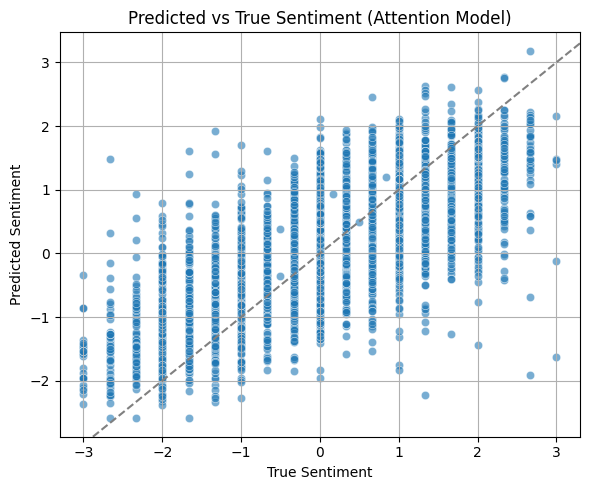

In [36]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=true_labels, y=preds, alpha=0.6)
plt.xlabel("True Sentiment")
plt.ylabel("Predicted Sentiment")
plt.title("Predicted vs True Sentiment (Attention Model)")
plt.grid(True)
plt.axline((0, 0), slope=1, linestyle='--', color='gray')  # 画 y = x 参考线
plt.tight_layout()
plt.show()

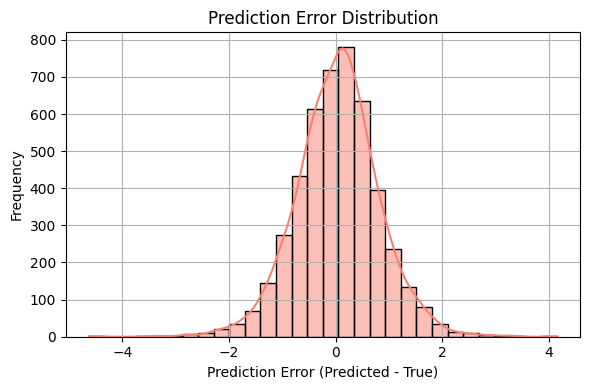

In [37]:
errors = np.array(preds) - np.array(true_labels)

plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=30, kde=True, color="salmon")
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (Predicted - True)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()